### **Part 4**
**Tasks**
* explore proper visual stimuli
  * spontaneous state
  * (done) evoked state: drifting
* Communication subspaces across different areas
  * (done) correlation
  * (done) dimensionality
    * intra_areas
    * inter_areas
* Information flow across subspaces
  * (done) direction: population correlation as the function of the time delay between areas ($t_2$-$t_1$)
  * intensity (correlation intensity)
* Hierarchy of information flow  across these subspaces
  * direction
    * (done) inter_areas cca_delay
    * *intra_areas cca_delay (layer_dependent)*
    * (done) feedfward and feedback
    * (done) input/output dimensions
  * function validation
* Relation between different information flow channels
  * *subspace & layer_dependent*
  * shared dimensionility
  * (done) generalize canonical dimension across subspaces
  * (done) subspaces angle
  * CCA across subspaces
  * predictive coding
* (to do) State dependent geometrical properties of these channels
* (to do) Dynamical system across areas modeled by multi-region RNN network
***************************************
(doing) 
* Layer dependent information flow
* Task8 Relation between area_subspace & layer_channel
**************************************

In [17]:
import os
import torch
import cupy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import subspace_angles
from sklearn.model_selection import KFold
from sklearn.decomposition import FactorAnalysis
from sklearn.cross_decomposition import CCA
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.core.reference_space_cache import ReferenceSpaceCache

In [251]:
# basepath = "E:\Allensdk_data\local\ecephys_cache_dir"
basepath = "/home/jialab/Allensdk_data/local/ecephys_cache_dir/"
manifest_path = os.path.join(basepath, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()
session_ids = [719161530, 750332458, 750749662, 754312389, 755434585, 756029989, 791319847, 797828357]
selected_sessions = {}

for i, session_id in enumerate(session_ids):
    session = cache.get_session_data(session_id)
    selected_sessions[session_id] = session

In [56]:
session = cache.get_session_data(755434585)
drift_stim_table = session.get_stimulus_table('drifting_gratings')
units_table = session.units
units_table.head()

,waveform_repolarization_slope,waveform_recovery_slope,cumulative_drift,max_drift,amplitude_cutoff,local_index_unit,firing_rate,waveform_amplitude,isolation_distance,waveform_velocity_above,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
951849410,0.880824,-0.159951,166.49,32.52,0.000776,1,25.971501,146.253510,40.857168,0.206030,...,313.0,MB,8459.0,3107.0,6915.0,probeA,See electrode locations,29999.954918,1249.998122,True
951849423,0.422568,-0.084614,669.67,43.18,0.081112,3,2.434690,92.465685,65.806882,1.373534,...,313.0,MB,8449.0,3086.0,6923.0,probeA,See electrode locations,29999.954918,1249.998122,True
951849448,0.209480,-0.051928,448.10,28.88,0.073300,7,4.099105,85.999485,86.873651,0.000000,...,10.0,SCig,8428.0,3037.0,6941.0,probeA,See electrode locations,29999.954918,1249.998122,True
951849441,0.898736,-0.347624,153.97,34.96,0.000886,6,10.696936,241.126470,103.843949,0.000000,...,313.0,MB,8431.0,3044.0,6939.0,probeA,See electrode locations,29999.954918,1249.998122,True
951851905,0.587173,-0.083528,342.44,25.03,0.060865,294,1.274454,143.344500,55.069390,0.274707,...,10.0,SCig,8406.0,2989.0,6959.0,probeA,See electrode locations,29999.954918,1249.998122,True


In [50]:
rsc_path = "/home/jialab/Allensdk_data/local/rsc_dir/"
reference_space_key = 'annotation/ccf_2017'
rsc_manifest_path = os.path.join(rsc_path, "manifest.json")
resolution = 10
rspc = ReferenceSpaceCache(resolution, reference_space_key, manifest=rsc_manifest_path)
annotation, meta = rspc.get_annotation_volume()
# ID 1 is the adult mouse structure graph
tree = rspc.get_structure_tree(structure_graph_id=1) 
rsp = rspc.get_reference_space()

In [264]:
def get_CCF_range_VIS(tree, areas, layers):

    CCF_range_VIS = {}
    for i, area in enumerate(areas):
        CCF_range_VIS[area] = {}
        for j, layer in enumerate(layers):
            if layer == '6':
                acronym_a = area + layer + 'a'
                acronym_b = area + layer + 'b'
                acronym_id_a = tree.get_structures_by_acronym([acronym_a])[0]['id']
                acronym_id_b = tree.get_structures_by_acronym([acronym_b])[0]['id']
                CCF_range = np.where((rsp.annotation == acronym_id_a)|(rsp.annotation == acronym_id_b))
            else:
                acronym = area + layer
                acronym_id = tree.get_structures_by_acronym([acronym])[0]['id']
                CCF_range = np.where(rsp.annotation == acronym_id)
                
            CCF_range_VIS[area][layer] = np.array(CCF_range).T

    return CCF_range_VIS

def get_VIS_layer_units(session, areas, layers, CCF_range_VIS):

    units_id = {}

    for i, area in enumerate(areas):
        units_id[area] = {}
        units_area = session.units[session.units["ecephys_structure_acronym"] == area]
        units_area_CCF = units_area[['anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate']]
        units_area_CCF = units_area_CCF.dropna(axis=0)
        units_area_CCF = units_area_CCF/10
        units_area_CCF = units_area_CCF.round().astype(int)
        units_area_CCF['unit_id'] = units_area_CCF.index

        for j, layer in enumerate(layers):
            CCF_range = pd.DataFrame(CCF_range_VIS[area][layer])
            CCF_range.columns = ['anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate']
            units_in_layer = pd.merge(CCF_range, units_area_CCF)
            units_id[area][layer] = np.array(units_in_layer['unit_id'])

    return units_id


def get_layer_units_num(areas, layers, VIS_layer_units):

    units_num = np.zeros((len(areas), len(layers)))
    for i, area in enumerate(areas):
        for j, layer in enumerate(layers):
            units_num[i][j] = VIS_layer_units[area][layer].shape[0]

    return units_num

def plot_VIS_layer_units(areas, layers, VIS_layer_units_num, units_areas, session_id):

    f, axes = plt.subplots(nrows=len(areas), ncols=1, figsize=(12, 24))
    width=0.6
    for i, area in enumerate(areas):
        axes[i].bar(range(len(layers)), VIS_layer_units_num[i, :], width=width)
        axes[i].set_title(f'units: {units_areas[i]}', fontsize=15)
        for x, y in zip(range(len(layers)), VIS_layer_units_num[i, :]):
            axes[i].text(x, y, y, ha='center', va='bottom', fontsize=15)
        axes[i].set_ylabel(f'{area}', fontsize=15)
        axes[i].set_xticks(range(len(layers)))
        axes[i].set_xticklabels(layers)
        axes[i].tick_params(axis='both', labelsize=15)
        axes[i].set_ylim(0, np.max(VIS_layer_units_num[i, :])+20)

    f.suptitle(f'VIS_layer_units in {session_id}', verticalalignment='bottom', fontsize=18)

    plt.tight_layout()
    plt.show()

In [194]:
areas = ['VISp', 'VISrl', 'VISl', 'VISal', 'VISpm', 'VISam']
layers = ['1', '2/3', '4', '5', '6']

CCF_range_VIS = get_CCF_range_VIS(tree, areas, layers)
np.save('CCF_range_VIS', CCF_range_VIS)
VIS_layer_units = get_VIS_layer_units(session, areas, layers, CCF_range_VIS)
np.save('VIS_layer_units_755434585', VIS_layer_units)
VIS_layer_units_num = get_layer_units_num(areas, layers, VIS_layer_units)

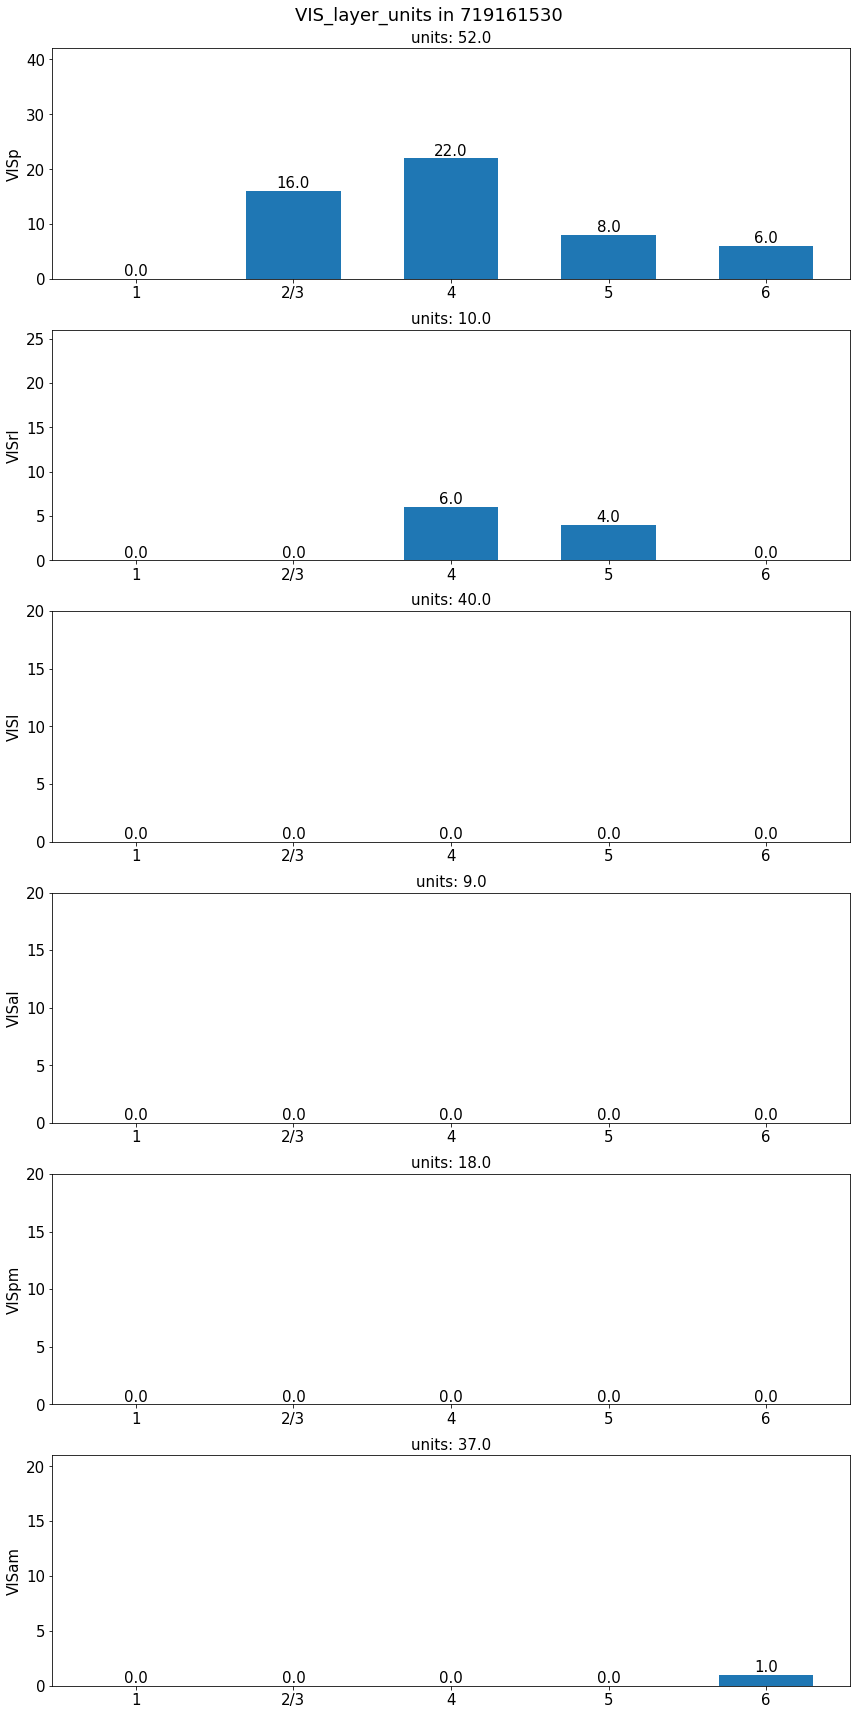

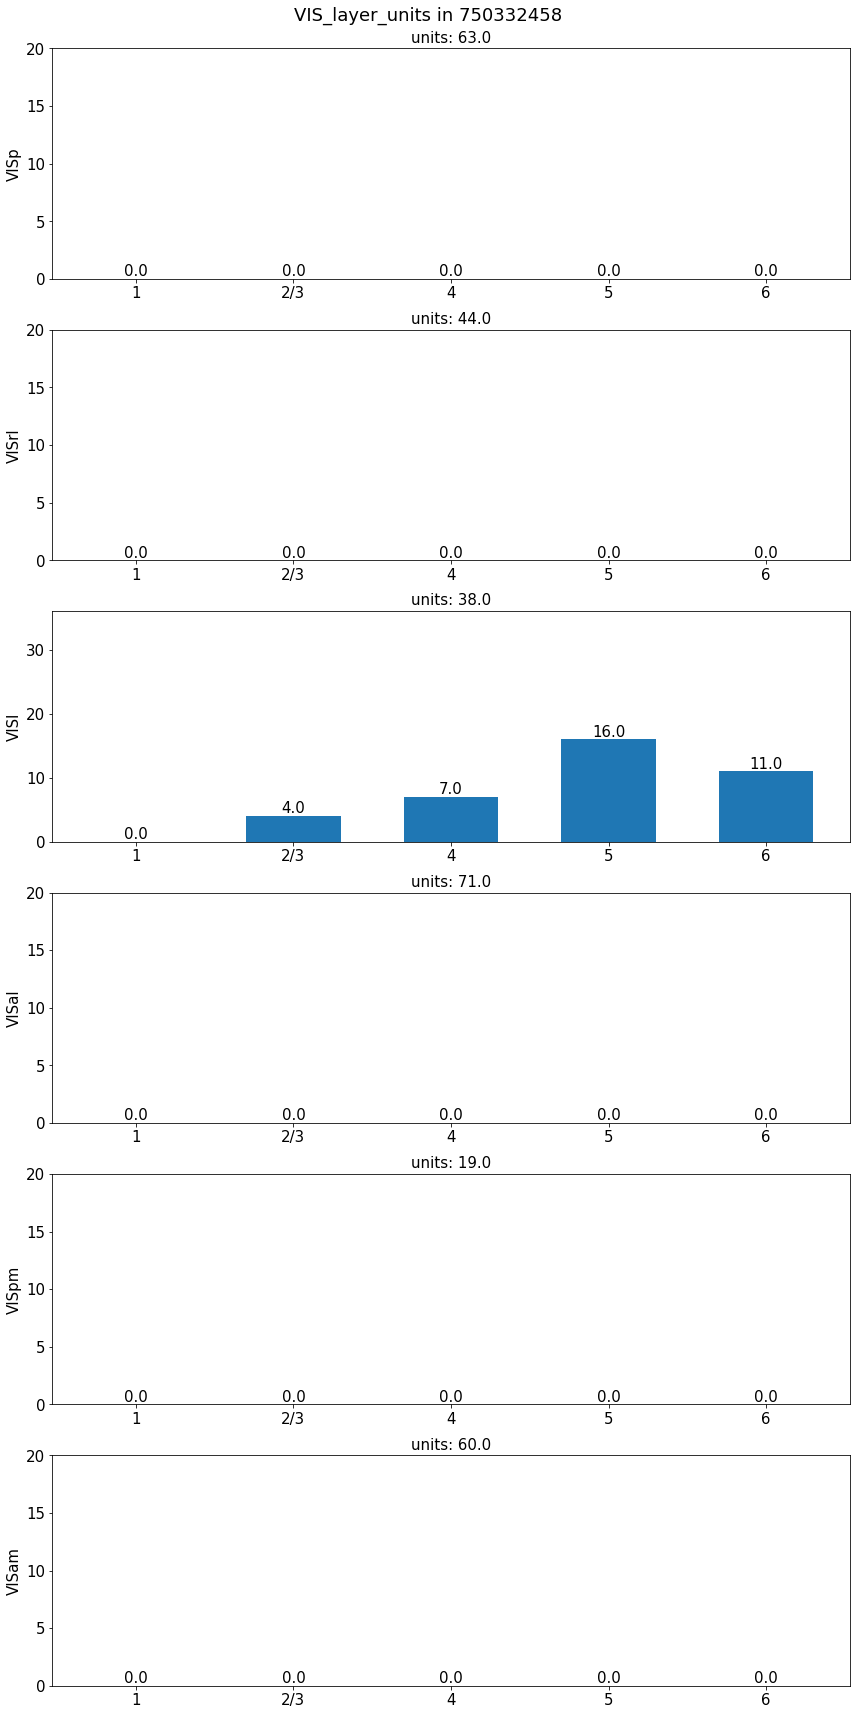

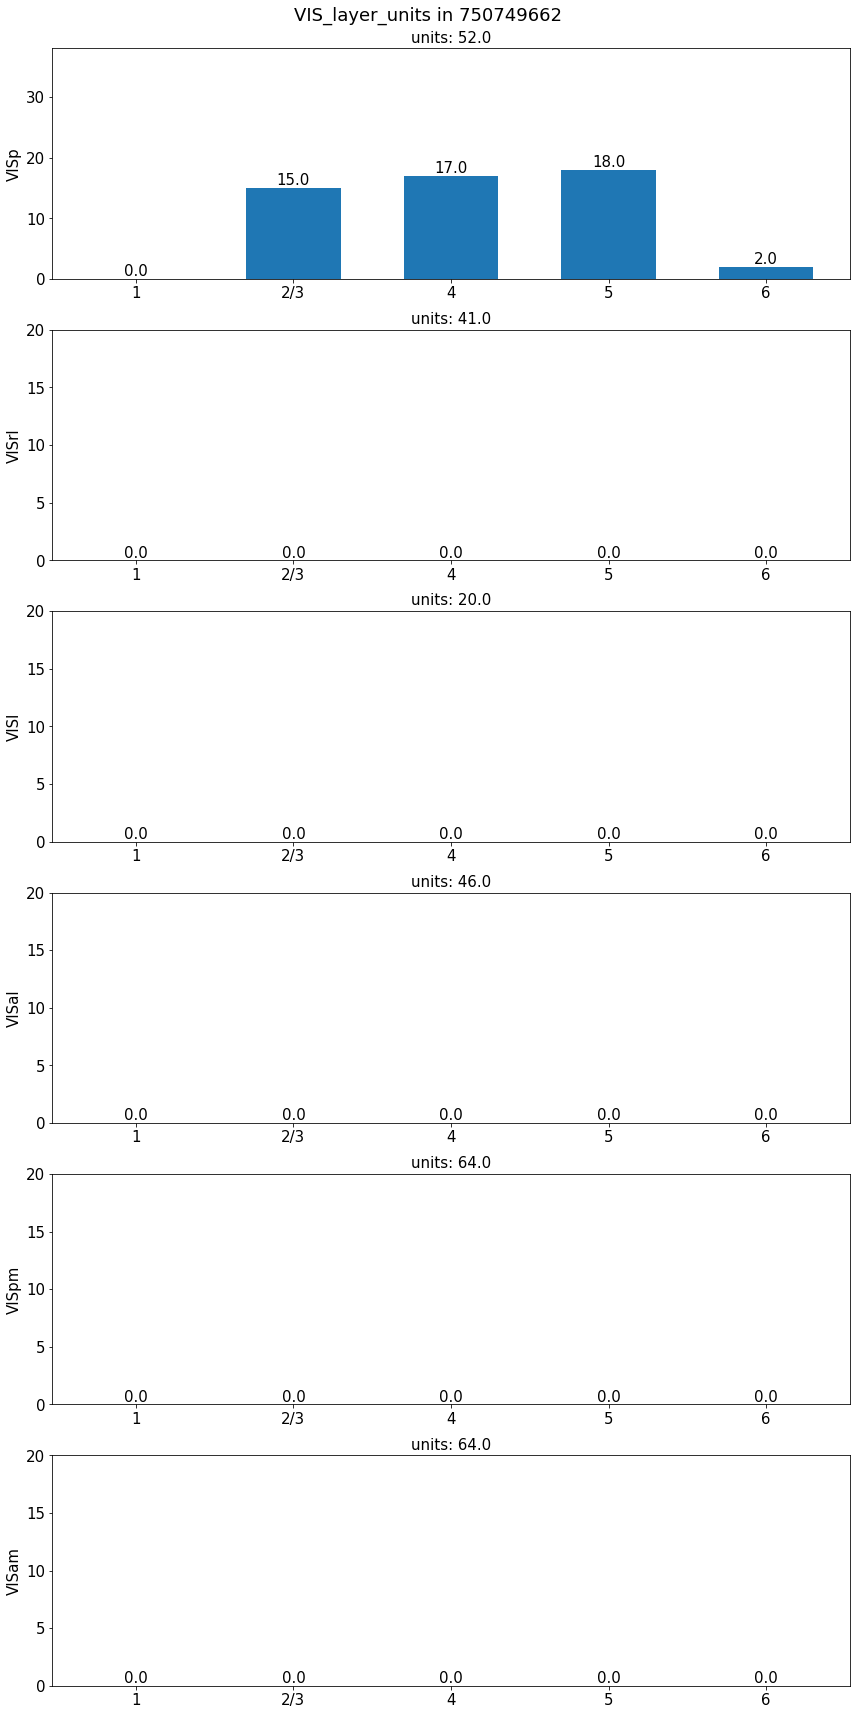

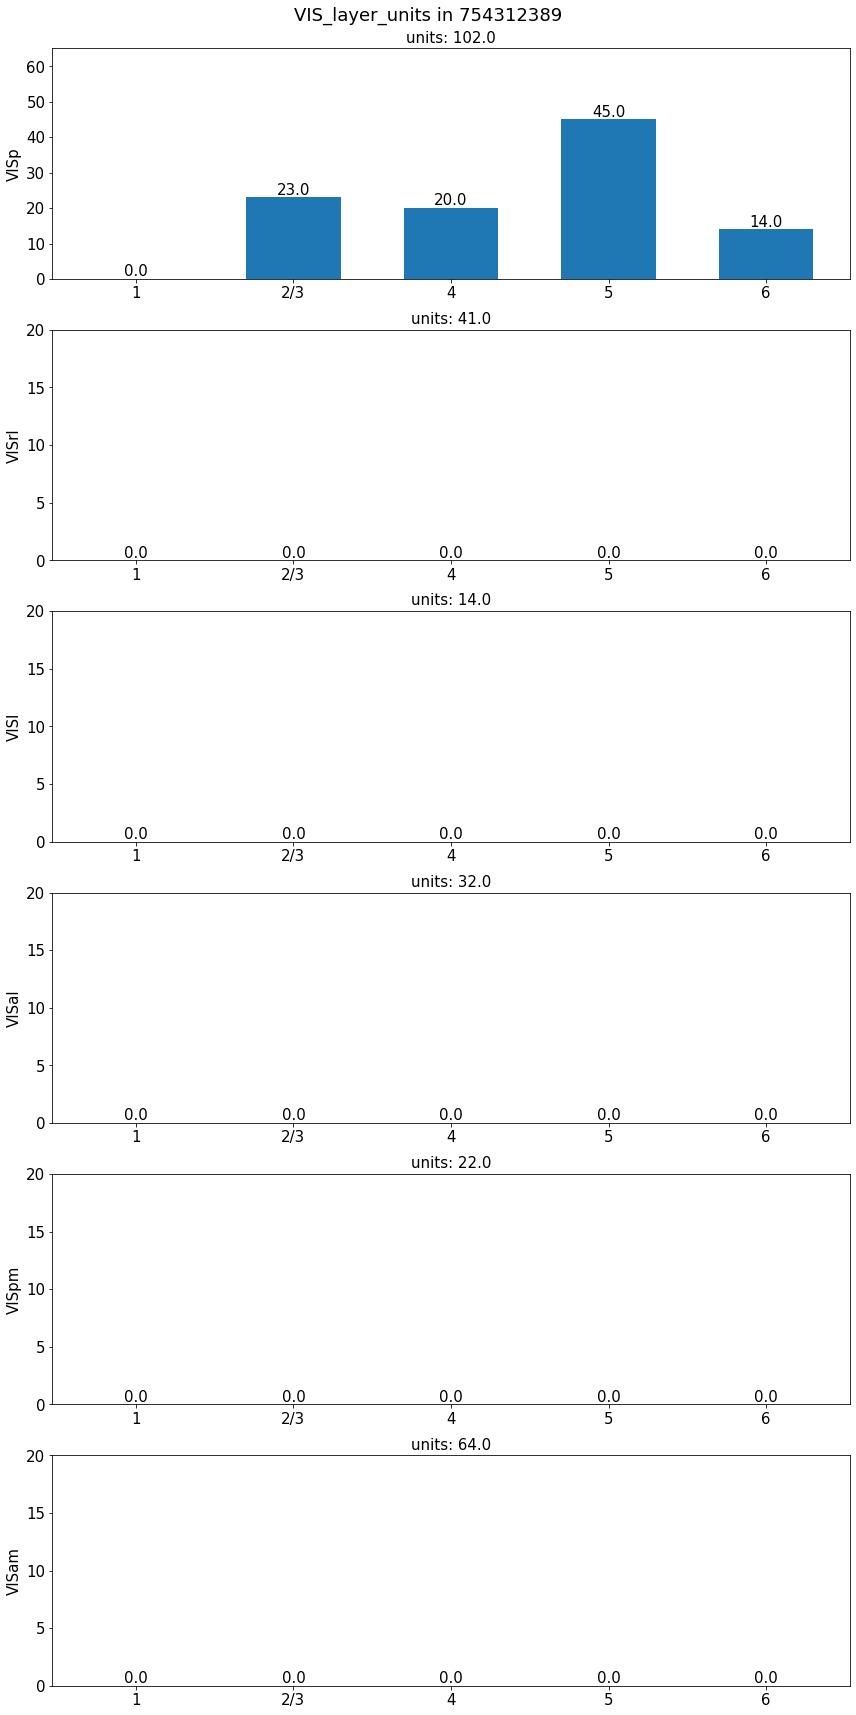

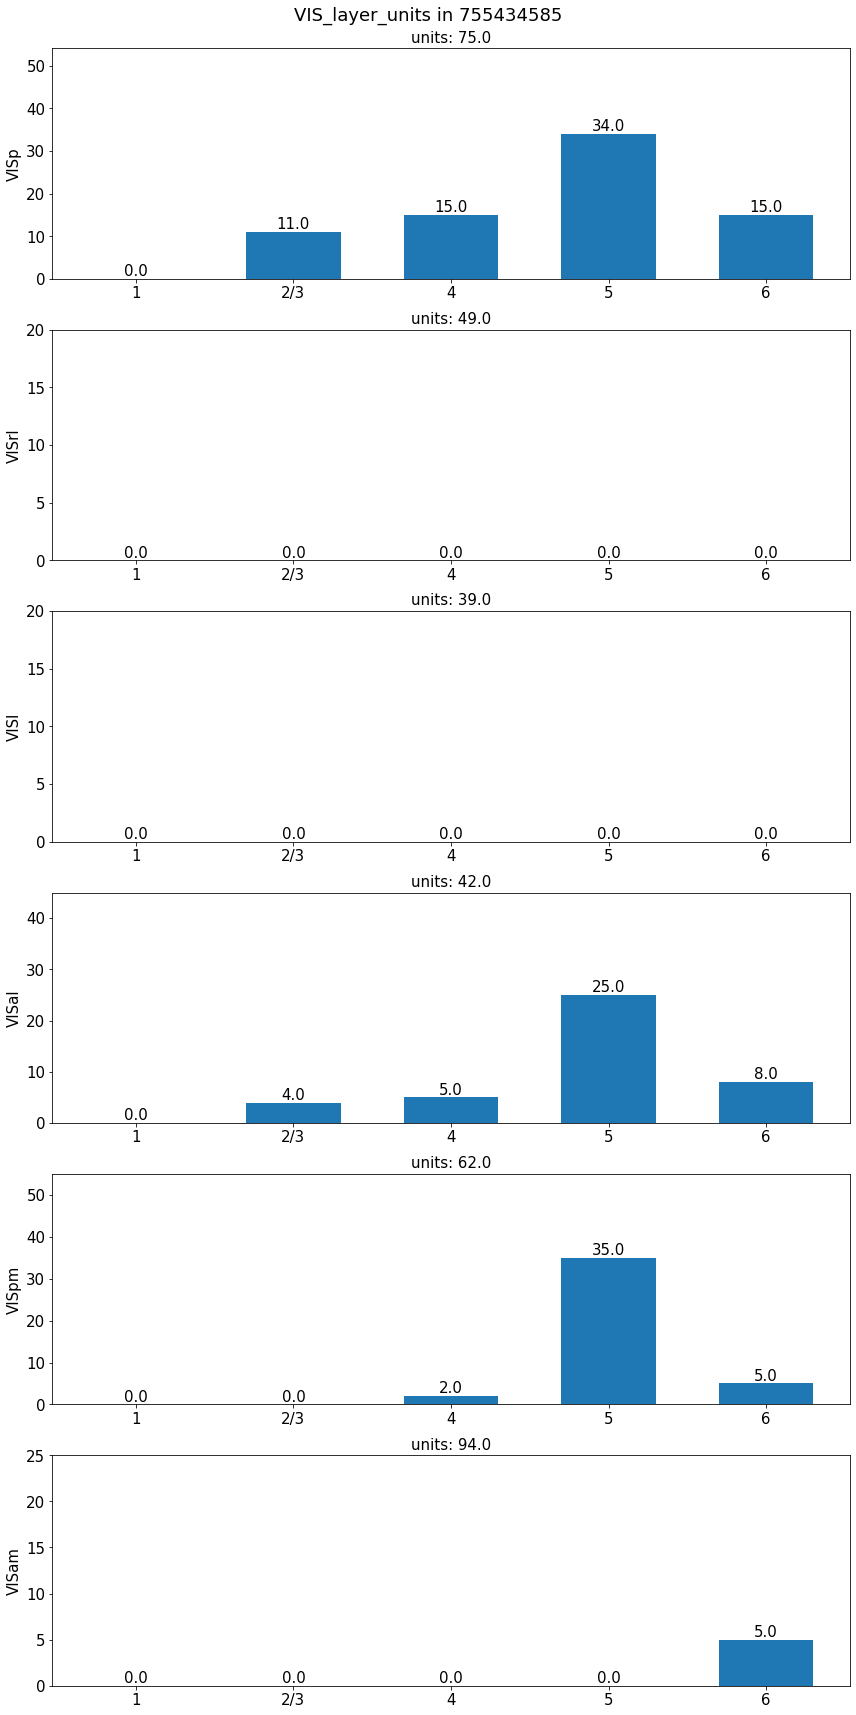

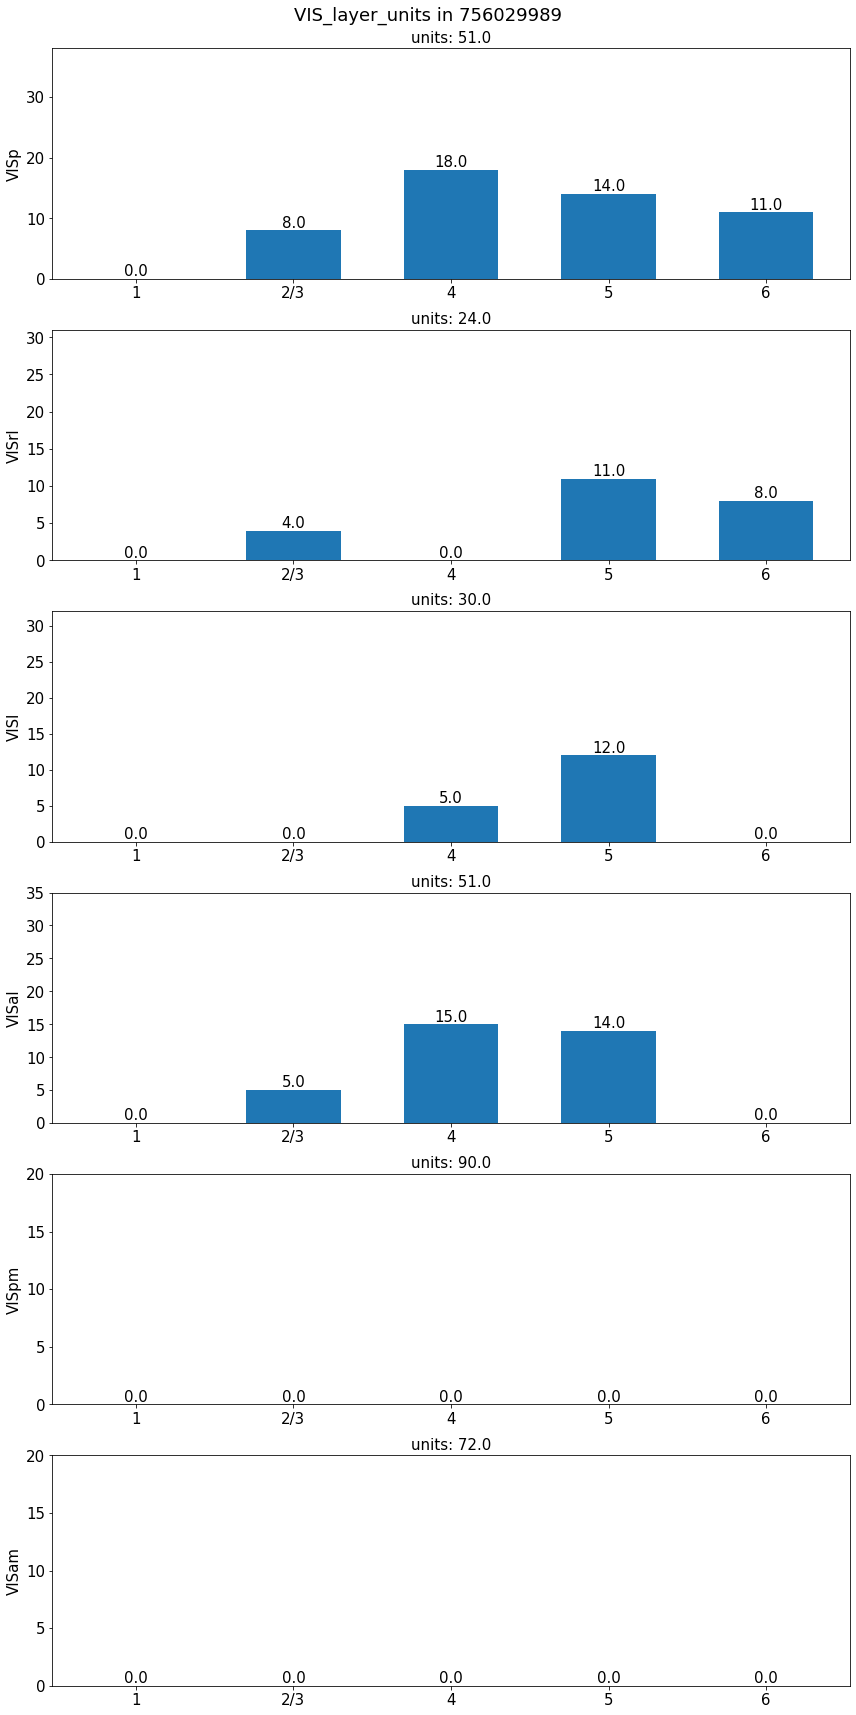

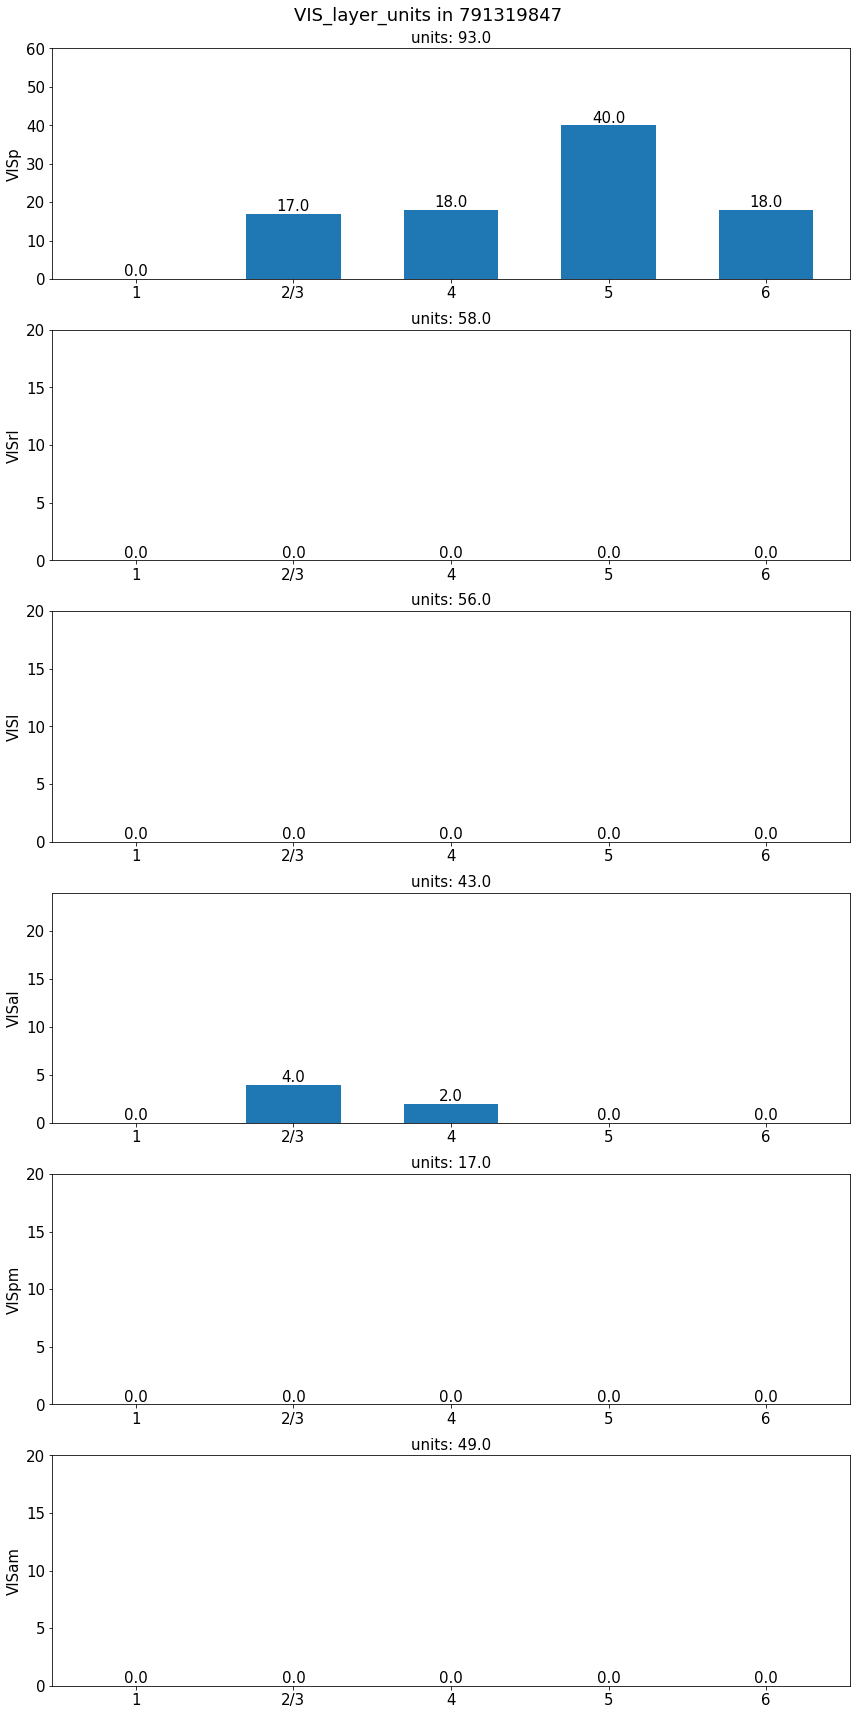

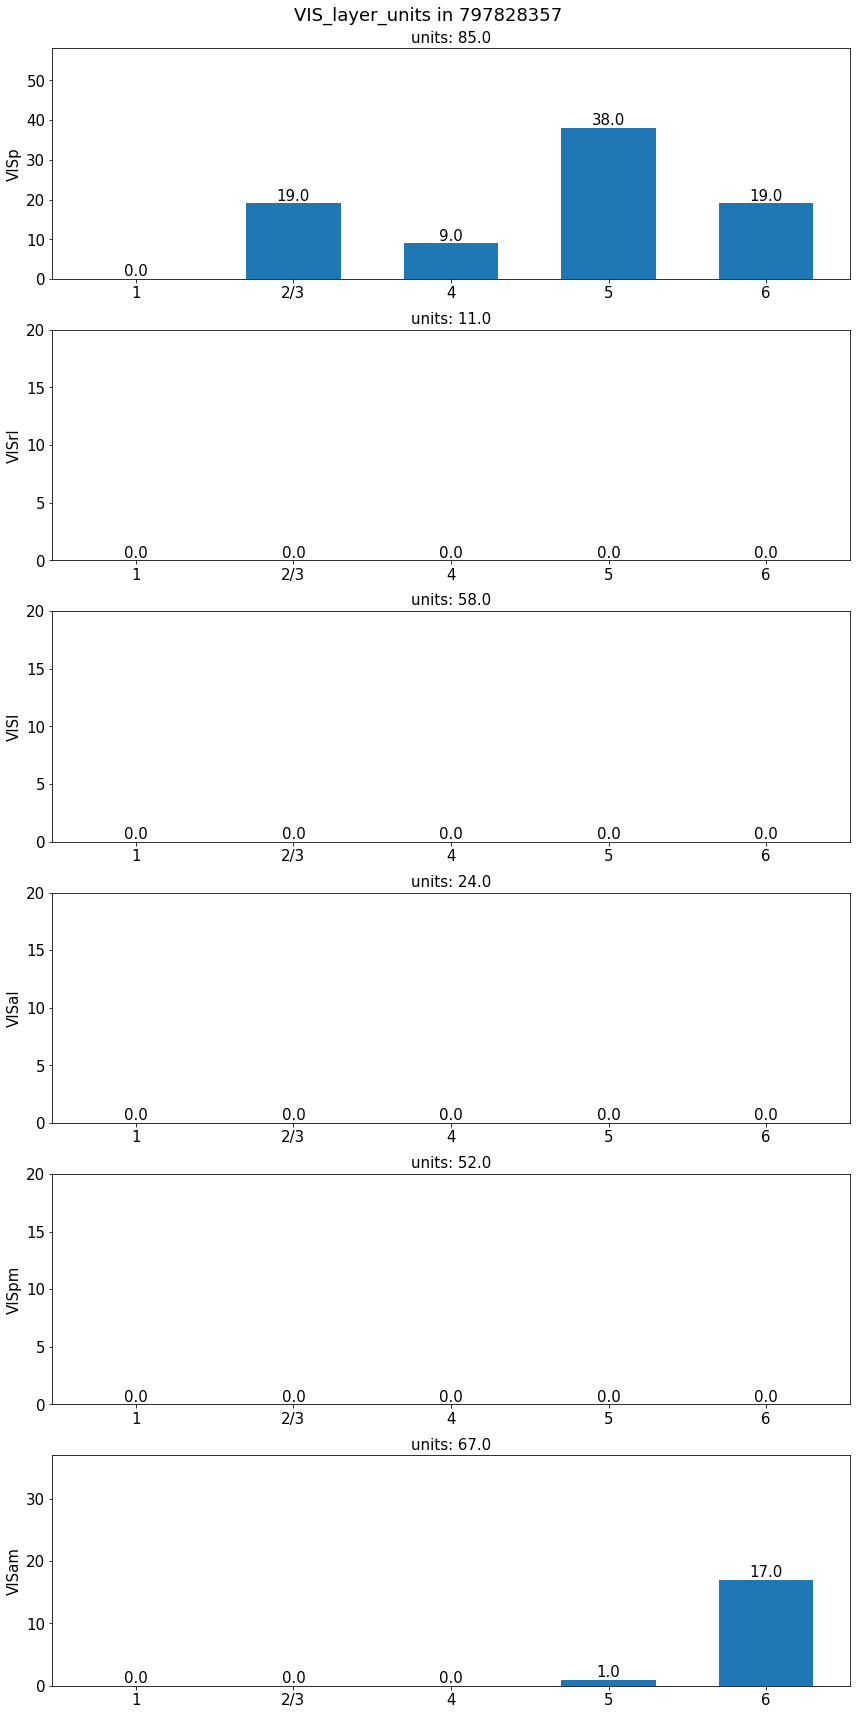

In [265]:
areas = ['VISp', 'VISrl', 'VISl', 'VISal', 'VISpm', 'VISam']
layers = ['1', '2/3', '4', '5', '6']
CCF_range_VIS = np.load('CCF_range_VIS.npy', allow_pickle=True).item()

for i, session_id in enumerate(session_ids):
    session = selected_sessions[session_id]
    VIS_layer_units = get_VIS_layer_units(session, areas, layers, CCF_range_VIS)
    np.save('VIS_layer_units_'+f'{session_id}', VIS_layer_units)
    VIS_layer_units_num = get_layer_units_num(areas, layers, VIS_layer_units)
    units_areas = np.load('units_areas_755434585.npy')[i]
    plot_VIS_layer_units(areas, layers, VIS_layer_units_num, units_areas, session_id)

In [260]:
area = 'VISam'
units_area = session.units[session.units["ecephys_structure_acronym"] == area]
units_area_CCF = units_area[['anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate']]
units_area_CCF = units_area_CCF/10
units_area_CCF = units_area_CCF.round().astype(int)
units_area_CCF.head()

,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate
unit_id,,,
951085724,746,120,722
951085746,745,117,724
951085764,745,115,725
951085752,745,116,724
951085769,744,114,725


In [263]:
CCF_range = pd.DataFrame(CCF_range_VIS['VISam']['1'])
print(CCF_range.shape)
CCF_range.columns = ['anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate']
print(CCF_range.head())
CCF_range.tail()

(136038, 3)
   anterior_posterior_ccf_coordinate  dorsal_ventral_ccf_coordinate  \
0                                708                             31   
1                                708                             31   
2                                708                             31   
3                                708                             31   
4                                708                             32   

   left_right_ccf_coordinate  
0                        432  
1                        433  
2                        706  
3                        707  
4                        432  


,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate
136033,812,36,426
136034,812,36,427
136035,812,36,712
136036,812,36,713
136037,812,36,714


In [262]:
df_0 = units_area_CCF
df_0['unit_id'] = df_0.index
df_1 = pd.merge(CCF_range, df_0)
id = np.array(df_1['unit_id'])
id.shape[0]

0

In [229]:
def get_units_area(areas, session):

    units_area = np.zeros(len(areas))

    for i, area in enumerate(areas):
        units_area[i] = session.units[session.units["ecephys_structure_acronym"] == area].shape[0]

    return units_area

def spike_matrix(area, stim_table, bin=0.1, period=2):
    """spike_matrix, get spike_counts using function "presentationwise_spike_counts"

    Arguments:
        area -- brain area, which need to be analyzed
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Keyword Arguments:
        bin -- count spikes within time bin, s (default: {0.1})
        period -- the whole time period of one stimuli in drift_grating_stimuli, s (default: {2})

    Returns:
        response_matrix, shape (stims, bins, units)
    """

    area_units = session.units[session.units["ecephys_structure_acronym"] == area]

    time_bins = np.arange(0, period + bin, bin)  

    spike_counts = session.presentationwise_spike_counts(
        stimulus_presentation_ids=stim_table.index.values,  
        bin_edges=time_bins,
        unit_ids=area_units.index.values
    )
    
    response_matrix = spike_counts.values

    return response_matrix

def get_design_matrix(area, stim_table):
    """get_design_matrix design_matrix for further analysis

    Reshape response_matrix from (stims, bins, units) to (stims*bins, units)/(n_samples, units)

    Arguments:
        area -- brain area, which need to be analyzed
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Returns:
        design_matrix, shape (n_samples, units)
    """

    response_matrix = spike_matrix(area=area, stim_table=stim_table)
    design_matrix = response_matrix.reshape(response_matrix.shape[0]*response_matrix.shape[1],
                                    response_matrix.shape[2])

    return design_matrix

In [230]:
areas = ['VISp', 'VISrl', 'VISl', 'VISal', 'VISpm', 'VISam', 'LGd', 'LP']
units_areas = np.zeros((len(session_ids), len(areas)))

for i, session_id in enumerate(session_ids):
    session = selected_sessions[session_id]
    units_areas[i, :] = get_units_area(areas, session)

plot_units_areas(units_areas, areas, session_ids)

KeyboardInterrupt: 

### Task7 Layer dependent information flow

### Task8 Relation between area_subspace & layer_channel

***********************************************************************
Below Code copy from part4 for debug
***********************************************************************

In [2]:
basepath = "/home/jialab/Allensdk_data/local/ecephys_cache_dir/"
manifest_path = os.path.join(basepath, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
session = cache.get_session_data(755434585)
drift_stim_table = session.get_stimulus_table('drifting_gratings')
drift_stim_table.head()

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,0.8,225,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1585.891887,2,drifting_gratings,1587.893537,1,2.00165,246
3799,0.8,270,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1588.894403,2,drifting_gratings,1590.896063,2,2.00166,247
3800,0.8,0,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1591.896927,2,drifting_gratings,1593.898597,8,2.00167,248
3801,0.8,0,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1594.899423,2,drifting_gratings,1596.901083,2,2.00166,249
3802,0.8,315,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1597.901957,2,drifting_gratings,1599.903567,2,2.00161,250


In [4]:
def cross_val_pCCA(des_mat, latent_dim):

    k_fold = 10
    kf = KFold(n_splits=k_fold)
    log_like = np.zeros(k_fold)

    fold = 0
    for train_index, test_index in kf.split(des_mat):
        train, test = des_mat[train_index], des_mat[test_index]
        # print("TRAIN:", train.shape, "TEST:", test.shape)

        fa = FactorAnalysis(n_components=latent_dim)
        fa.fit(train)

        log_like[fold] = fa.score(test)   # get Average log-likelihood of test
        fold = fold + 1

    return log_like.mean()

def inter_dim_pCCA(des_mat_1, des_mat_2):
    
    des_mat = np.concatenate((des_mat_1, des_mat_2), axis = 1)

    N, n_features = des_mat.shape
    _, n_features_1 = des_mat_1.shape
    _, n_features_2 = des_mat_2.shape

    # select proper latent dimensions from [1, n_features-1]
    cv_log_like = np.zeros(n_features-1)
    for i in range(n_features-1):
        latent_dim = i + 1
        cv_log_like[i] = cross_val_pCCA(des_mat, latent_dim)

    latent_dim_log_like = np.argmax(cv_log_like) + 1
    print('latent_dim_log_like', latent_dim_log_like)

    # select proper latent dimensions with best dim got by log_like
    fa = FactorAnalysis(n_components=latent_dim_log_like)
    fa.fit(des_mat)
    load_mat = fa.components_   # (n_components, n_features)
    load_mat_1 = load_mat[:, :n_features_1]
    load_mat_2 = load_mat[:, n_features_1:]

    _, sing_vals, _ = np.linalg.svd(load_mat_1.T @ load_mat_2)

    shared_var = np.cumsum(sing_vals)/np.sum(sing_vals)

    threshold = 0.9
    latent_dim = np.where(shared_var>threshold)[0][0]
    print('latent_dim', latent_dim)

    # use the proper latent_dim to fit
    fa = FactorAnalysis(n_components=latent_dim)
    fa.fit(des_mat)
    load_mat = fa.components_   # (n_components, n_features)
    load_mat_1 = load_mat[:, :n_features_1]
    load_mat_2 = load_mat[:, n_features_1:]

    return latent_dim, (load_mat_1, load_mat_2)

def get_inter_dim_area(areas, stim_table):

    inter_dim_areas = np.zeros([len(areas), len(areas)])

    for i, area_1 in enumerate(areas):
        des_mat_1 = get_design_matrix(area_1, stim_table)
        for j, area_2 in enumerate(areas):
            des_mat_2 = get_design_matrix(area_2, stim_table)
            inter_dim_areas[i, j], _ = inter_dim_pCCA(des_mat_1, des_mat_2)
            
    print('inter_dim_areas', inter_dim_areas)

    return inter_dim_areas

def plot_inter_dim_areas(areas, intra_dim_area, inter_dim_areas):
    # inter_dimension across every two areas

    f, axes = plt.subplots(nrows=len(areas), ncols=1, figsize=(24, 50), sharex=True)

    width=0.25
    x = np.array(range(len(areas)))
    intra_dim_area_2 = intra_dim_area

    for i, area_1 in enumerate(areas):

        intra_dim_area_1 = np.ones_like(x) * intra_dim_area[i]

        axes[i].bar(x, intra_dim_area_1, width=width, label='intra_dim_1', fc='r') 
        axes[i].bar(x+np.array([width]), inter_dim_areas[i, :], width=width, label='inter_dim', fc='g')
        axes[i].bar(x+np.array([2*width]), intra_dim_area_2, width=width, label='intra_dim_2', tick_label=areas, fc='b')
        axes[i].set_ylabel(f'{area_1}')
        axes[i].legend()

    f.suptitle('inter_dimension & intra_dimension across every two areas')
    plt.tight_layout()
    plt.show()

In [5]:
area = 'VISl'
latent_dim = 20
des_mat = get_design_matrix(area, stim_table=drift_stim_table)
cv_log_like = cross_val_pCCA(des_mat, latent_dim)

In [111]:
def pCCA_subspaces_angle(area_x, area_y1, area_y2, pCCA_load_mat_1, pCCA_load_mat_2):
    """pCCA_subspaces_angle, get angles of subspaces via pCCA

    To identify the relation between subspaces got by (pCCA for area_x & area_y1) and (pCCA for area_x & area_y2)
    Use pCCA for area_x & area_y1, we can get information flow subspace (spanned by load_mat_xy1) of area_x and area_y1;
    Use pCCA for area_x & area_y2, we can get information flow subspace (spanned by load_mat_xy2) of area_x and area_y2;
    Then, by calculating the angle between these subspaces load_mat_xy1 & load_mat_xy2,
    we find that when area_x exchange information with area_y1 & area_y2, it use different subspaces.

    there are three relations of information flow between area_x, area_y1, area_y2:
    1. area_x  --->  area_y1 & area_x  --->  area_y2
    2. area_y1  --->  area_x & area_x  --->  area_y2
    3. area_y1  --->  area_x & area_y2  --->  area_x

    Arguments:
        area_x -- an area have information flow with both area_y1 & area_y2
        area_y1 -- an area have information flow with area_x
        area_y2 -- an area have information flow with area_x
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Returns:
        subspaces_angle -- the angle of subspaces load_mat_xy1 & load_mat_xy2
    """

    # des_mat_x = get_design_matrix(area_x, stim_table)
    # des_mat_y1 = get_design_matrix(area_y1, stim_table)
    # des_mat_y2 = get_design_matrix(area_y2, stim_table)

    # _, (load_mat_xy1, _) = inter_dim_pCCA(des_mat_x, des_mat_y1)
    # _, (load_mat_xy2, _) = inter_dim_pCCA(des_mat_x, des_mat_y2)
    # print('load_mat_xy1', load_mat_xy1.shape)
    # print('load_mat_xy2', load_mat_xy2.shape)

    name_1 = area_x + '_' + area_y1
    name_2 = area_x + '_' + area_y2
    load_mat_xy1 = pCCA_load_mat_1[name_1]
    load_mat_xy2 = pCCA_load_mat_1[name_2]

    subspaces_angle = np.rad2deg(subspace_angles(load_mat_xy1.T, load_mat_xy2.T)[0])

    return subspaces_angle

def plot_subspaces_angles_area(area_1, areas_2, areas_3, subspaces_angles):

    fig, axes = plt.subplots(nrows=len(areas_2), ncols=1, figsize=(12, 24))

    for i, area_2 in enumerate(areas_2):

        axes[i].plot(range(len(areas_3)), subspaces_angles[i, :])
        axes[i].set_xticks(range(len(areas_3)))
        axes[i].set_xticklabels(areas_3, fontsize=13)
        # axes[i].set_yticklabels(fontsize=13)
        axes[i].set_ylabel(f'{area_2}', fontsize=15)
        # axes[i].set_title(f'dims_angles between {area_2} with', fontsize=15)

    fig.suptitle(f'dims_angles in {area_1}', verticalalignment='bottom', fontsize=18)
    fig.tight_layout()
    plt.show()

    return

In [105]:
def cross_val_FA(des_mat, latent_dim):

    k_fold = 10
    kf = KFold(n_splits=k_fold)
    log_like = np.zeros(k_fold)

    fold = 0
    for train_index, test_index in kf.split(des_mat):
        train, test = des_mat[train_index], des_mat[test_index]
        # print("TRAIN:", train.shape, "TEST:", test.shape)

        fa = FactorAnalysis(n_components=latent_dim)
        fa.fit(train)


        log_like[fold] = fa.score(test)   # get Average log-likelihood of test
        fold = fold + 1

    return log_like.mean()

def intra_dim_FA(des_mat):
    
    N, n_features = des_mat.shape

    # select proper latent dimensions from [1, p-1]
    cv_log_like = np.zeros(n_features-1)
    for i in range(n_features-1):
        latent_dim = i + 1
        cv_log_like[i] = cross_val_FA(des_mat, latent_dim)

    latent_dim_log_like = np.argmax(cv_log_like) + 1

    # select proper latent dimensions with best dim got by log_like
    fa = FactorAnalysis(n_components=latent_dim_log_like)
    fa.fit(des_mat)
    load_mat = fa.components_   # (n_components, n_features)

    eigvals, eigvecs = np.linalg.eig(load_mat.T @ load_mat)
    ind = np.argsort(-eigvals)
    eigvals = eigvals[ind]
    shared_var = np.cumsum(eigvals)/np.sum(eigvals)

    threshold = 0.9
    latent_dim = np.where(shared_var>threshold)[0][0]

    return latent_dim, cv_log_like, latent_dim_log_like


def get_intra_dim_area(areas, stim_table):

    intra_dim_area = np.zeros(len(areas))

    for i, area in enumerate(areas):
        des_mat = get_design_matrix(area, stim_table)
        intra_dim_area[i] = intra_dim_FA(des_mat)

    print('intra_dim_area', intra_dim_area)

    return intra_dim_area

def plot_intra_dim_areas(areas, units_area, intra_dim_area):

    # intra_dimension for all areas
    x = np.array(range(len(areas)))
    width=0.4
    plt.figure(figsize=(16, 10))
    plt.bar(x, units_area, width=width, label='units',fc='y')
    plt.bar(x+np.array([width]), intra_dim_area, width=width, label='intra_dimensions', tick_label=areas, fc='r')
    plt.legend()

    # show num on the bar
    for a, b in zip(x, units_area):
        plt.text(a, b, b, ha='center', va='bottom')
    for a, b in zip(x+width, intra_dim_area):
        plt.text(a, b, b, ha='center', va='bottom')

    plt.title(f'intra_dim & units in different areas')
    plt.show()

    return

latent_dim_log_like 32
latent_dim 14


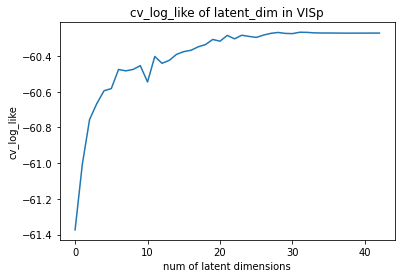

In [8]:
area = 'LGd'
des_mat = get_design_matrix(area, stim_table=drift_stim_table)
latent_dim, cv_log_like, latent_dim_log_like = intra_dim_FA(des_mat)
print('latent_dim_log_like', latent_dim_log_like)
print('latent_dim', latent_dim)

plt.figure()
plt.plot(cv_log_like)
plt.title(f'cv_log_like of latent_dim in VISp')
plt.xlabel('num of latent dimensions')
plt.ylabel('cv_log_like')
plt.show()

subspaces_angles [[1.65922359e-13 2.45055361e+01 2.61242169e+01 2.50476041e+01
  1.96820012e+01 2.76414377e+01 3.55387082e+01 2.71818369e+01]
 [2.45055361e+01 1.44962862e-13 4.19545067e+01 8.23549141e+01
  4.51347689e+01 2.76132290e+01 3.36673205e+01 4.07672061e+01]
 [2.61242169e+01 4.19545067e+01 1.41985014e-13 8.08172122e+01
  2.70255578e+01 2.25355684e+01 2.29095806e+01 2.94041950e+01]
 [2.50476041e+01 8.23549141e+01 8.08172122e+01 1.07695270e-13
  6.40835983e+01 4.99895915e+01 3.62165539e+01 6.40991991e+01]
 [1.96820012e+01 4.51347689e+01 2.70255578e+01 6.40835983e+01
  1.37888535e-13 1.67095633e+01 2.53746008e+01 2.96063159e+01]
 [2.76414377e+01 2.76132290e+01 2.25355684e+01 4.99895915e+01
  1.67095633e+01 1.67949020e-13 7.89069262e+01 4.89071246e+01]
 [3.55387082e+01 3.36673205e+01 2.29095806e+01 3.62165539e+01
  2.53746008e+01 7.89069262e+01 1.15159601e-13 1.70565403e+01]
 [2.71818369e+01 4.07672061e+01 2.94041950e+01 6.40991991e+01
  2.96063159e+01 4.89071246e+01 1.70565403e+01

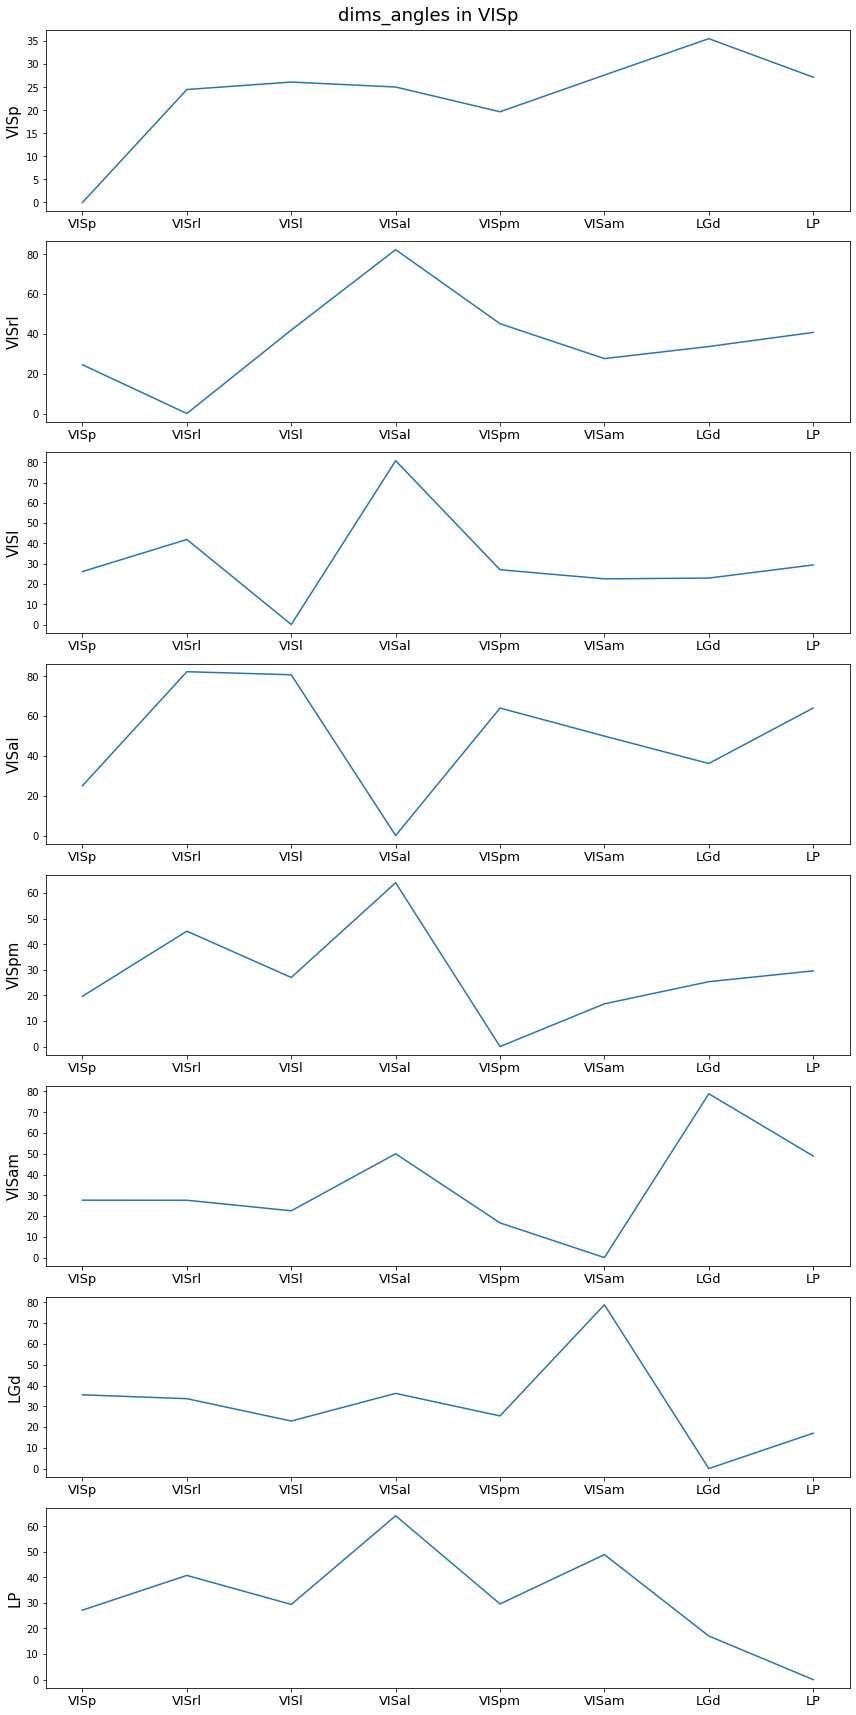

In [112]:
area_1 = 'VISp'
areas_2 = ['VISp', 'VISrl', 'VISl', 'VISal', 'VISpm', 'VISam', 'LGd', 'LP']
areas_3 = ['VISp', 'VISrl', 'VISl', 'VISal', 'VISpm', 'VISam', 'LGd', 'LP']

pCCA_load_mat_1 = np.load('pCCA_load_mat_1_755434585.npy', allow_pickle=True).item()
pCCA_load_mat_2 = np.load('pCCA_load_mat_2_755434585.npy', allow_pickle=True).item()
subspaces_angles = np.zeros((len(areas_2), len(areas_3)))

for i, area_2 in enumerate(areas_2):
    for j, area_3 in enumerate(areas_3):
        subspaces_angles[i, j] = pCCA_subspaces_angle(area_1, area_2, area_3, pCCA_load_mat_1, pCCA_load_mat_2)

np.save('subspaces_angles_755434585', subspaces_angles)
print('subspaces_angles', subspaces_angles)
plot_subspaces_angles_area(area_1, areas_2, areas_3, subspaces_angles)